In [2]:
import argparse
import json
import logging
import os
import random
import time
import textwrap

import torch
import numpy as np

from scipy.spatial.transform import Rotation
from scipy.spatial.distance import pdist, cdist, squareform

from PIL import Image
from PIL.Image import Image as PilImage
import matplotlib.pyplot as plt

In [3]:
import sys 

def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)

THIS_DIR = os.path.dirname('./')
LIB_PATH = os.path.join(THIS_DIR, '..')
add_path(LIB_PATH)

import utils.misc as ws
import utils.data_utils
import utils.train_utils
import utils.eval_utils
import utils.mesh


In [4]:
def get_actual_idx(training_contact_maps, global_idx):
    _path_split = training_contact_maps[global_idx].split("/")
    return (_path_split[-2], _path_split[-1].split(".")[0].split("_")[-1])

def val_get_gripper_idx():
    pass

In [5]:
def get_reconstructed_code_filename(experiment_dir, epoch, ycb_model, gripper_name, instance_name):
    return os.path.join(
        experiment_dir,
        reconstructions_subdir,
        str(epoch),
        reconstruction_codes_subdir,
        f"{ycb_model}-sdf-{gripper_name}-{instance_name}.pth")
    # ycb_model + '-sdf-' + gripper_name + '-' + instance_name + ".pth")

In [6]:
dataset_dir = os.path.join(LIB_PATH, '../dataset_train/')
validation_dir = os.path.join(LIB_PATH, '../dataset_validation/')

# object_model = "003_cracker_box_google_16k_textured_scale_1000"
object_model = "005_tomato_soup_can_google_16k_textured_scale_1000"

EXPERIMENTS_DIR = '../experiments/all5_005_dsdf_50_varcmap'

reconstructions_subdir = ws.reconstructions_subdir
reconstruction_codes_subdir = ws.reconstruction_codes_subdir

trn_images_dir = os.path.join(dataset_dir, object_model, "images")
val_images_dir = os.path.join(validation_dir, object_model, "images")

trn_contactmap_dir = os.path.join(dataset_dir, object_model, "contactmap")
val_contactmap_dir = os.path.join(validation_dir, object_model, "contactmap")

CHECKPOINT = 'latest'
trn_split_file = os.path.join(EXPERIMENTS_DIR, 'split_train.json')
val_split_file = os.path.join(EXPERIMENTS_DIR, 'split_validation.json')
specs_filename = os.path.join(EXPERIMENTS_DIR, "specs.json")

LATENT_CODE_DIR = ws.latent_codes_subdir

In [7]:
with open(trn_split_file, 'r') as f:
    trn_data_split = json.load(f)

with open(val_split_file, 'r') as f:
    val_data_split = json.load(f)

saved_model_state = torch.load(
    os.path.join(
        EXPERIMENTS_DIR, ws.model_params_subdir, CHECKPOINT + ".pth")
)
saved_model_epoch = saved_model_state["epoch"]

In [8]:
# LOADS THE TRAINING DATA SET
trn_cmap_f, trn_grp_names, trn_gpc_f, trn_npz_filenames = utils.data_utils.get_instance_filelist(
    dataset_dir, trn_data_split)
trn_cmaps = utils.data_utils.construct_cmap_array(trn_cmap_f)
print(f"Training cmaps loaded. Shape: {trn_cmaps.shape}")

Training cmaps loaded. Shape: (250, 8178)


In [9]:
# LOADS THE VALIDATION DATA SET
val_cmap_f, val_grp_names, val_gpc_f, val_npz_filenames = utils.data_utils.get_instance_filelist(
    validation_dir, val_data_split)
val_cmaps = utils.data_utils.construct_cmap_array(val_cmap_f)
print(f"Validation cmaps loaded. Shape: {val_cmaps.shape}")

Validation cmaps loaded. Shape: (25, 8178)


In [10]:
# Load the train latent vectors
specs = json.load(open(specs_filename))
latent_size = specs["CodeLength"]
trn_latent_vecs = ws.load_latent_vectors(EXPERIMENTS_DIR, CHECKPOINT)
print(latent_size, trn_latent_vecs.shape)
trn_lv = trn_latent_vecs.cpu().numpy()
print(f"Training LVs loaded. Shape: {trn_lv.shape}")
# trn_lv_dist = squareform(pdist(trn_lv, metric='cityblock'))
# print(trn_lv_dist.shape)

128 torch.Size([250, 128])
Training LVs loaded. Shape: (250, 128)


In [11]:
# Load the VAL latent vectors
N = len(val_npz_filenames)
d = latent_size
val_lv = np.empty((N, d))
for idx in range(len(val_npz_filenames)):
    gripper = val_grp_names[idx]
    npz = val_npz_filenames[idx]
    # full_filename = npz
    # print(idx, npz[-35:])
    npz_instance_name = os.path.split(npz)[-1].split('.')[0]
    lvec_file = get_reconstructed_code_filename(EXPERIMENTS_DIR, saved_model_epoch,
                                                object_model, gripper, npz_instance_name)
    lvec_idx = torch.load(lvec_file)
    lvec_idx = lvec_idx.squeeze()
    val_lv[idx] = lvec_idx.cpu().detach().numpy()
print(f"Validation LVs loaded. Shape: {val_lv.shape}")

Validation LVs loaded. Shape: (25, 128)


In [12]:
# Create distance matrix between VAL and TRN Contact Maps
lvdist_val_to_trn = cdist(val_lv, trn_lv, metric='cityblock')
lvdist_val_to_trn /= np.max(lvdist_val_to_trn)
lvsim_val_to_trn = 1 - lvdist_val_to_trn
print(f"Dist matrix over LVs val -> trn construced. Shape: {lvdist_val_to_trn.shape}")

# Create distance matrix between VAL and TRN Latent Vecs
cmapdist_val_to_trn = cdist(val_cmaps, trn_cmaps, metric='cityblock')
cmapdist_val_to_trn /= np.max(cmapdist_val_to_trn)
cmapsim_val_to_trn = 1 - cmapdist_val_to_trn
print(f"Dist matrix over Cmaps val -> trn construced. Shape: {cmapdist_val_to_trn.shape}")

Dist matrix over LVs val -> trn construced. Shape: (25, 250)
Dist matrix over Cmaps val -> trn construced. Shape: (25, 250)


In [ ]:
# # Debugging: Create val->val cmap and lv dist
# cmapdist_val_to_val = utils.data_utils.construct_cmap_dist(val_cmap_f)

# lvdist_val_to_val = squareform(pdist(val_lv, metric='cityblock'))
# lvdist_val_to_val /= np.max(lvdist_val_to_val)

In [16]:
def check_matches(cmap_dist, lv_dist, extreme_end=5):
    count_top1 = 0
    count_topK = 0
    N = len(cmap_dist)
    for q in range(N):
        topK_query_cmap = np.argsort(cmap_dist[q])
        topK_query_lv = np.argsort(lv_dist[q])
        # print(topK_query_cmap.shape, topK_query_lv.shape)

        # top-1
        if topK_query_cmap[0] == topK_query_lv[0]:
            count_top1 += 1        
        if topK_query_cmap[0] in topK_query_lv[0:extreme_end]:
        # if topK_query_lv[0] in topK_query_cmap[0:extreme_end]:    
            # print(q)
            count_topK += 1

    return count_top1/N, count_topK/N

# def check_avg_sim(cmap_dist, lv_dist, cmap_sim, extreme_end=5):
#     sim_top1 = 0
#     sim_topK = 0
#     N = len(cmap_dist) # number of validation samples
#     for q in range(N):
#         # topK_query_cmap = np.argsort(cmap_dist[q])
#         topK_query_lv = np.argsort(lv_dist[q])
#         # if topK_query_cmap[0] == topK_query_lv[0]:
#         sim_top1 += cmap_sim[q][topK_query_lv[0]]
#         # if topK_query_cmap[0] in topK_query_lv[0:extreme_end]:    
#         sim_topK += np.mean(cmap_sim[q][:extreme_end])

#     return sim_top1/N, sim_topK/N

def check_avg_sim(cmap_dist, lv_dist, cmap_sim, K=1):
    sim_topK = 0
    sim_cmap = 0
    far_topK = 0
    far_cmap = 0
    N = len(cmap_dist) # number of validation samples
    for q in range(N):
        topK_query_cmap = np.argsort(cmap_dist[q])
        topK_query_lv = np.argsort(lv_dist[q])
        # nearest
        sim_topK += np.mean(cmap_sim[q][topK_query_lv[:K]])
        sim_cmap += np.mean(cmap_sim[q][topK_query_cmap[:K]])
        # farthest
        far_topK += np.mean(cmap_sim[q][topK_query_lv[-K:]])
        far_cmap += np.mean(cmap_sim[q][topK_query_cmap[-K:]])


    return sim_topK/N, sim_cmap/N, far_topK/N, far_cmap/N


In [21]:
def print_minmax(arr):
    print(np.min(arr), np.max(arr))

print_minmax(cmapsim_val_to_trn)
print_minmax(cmapdist_val_to_trn)

# print_minmax(lvsim_val_to_trn)
# print_minmax(lvdist_val_to_trn)

0.0 0.98172620563334
0.01827379436665995 1.0


In [17]:
print("K=1", check_avg_sim(cmapdist_val_to_trn, lvdist_val_to_trn, cmapsim_val_to_trn, 1))
print("K=3", check_avg_sim(cmapdist_val_to_trn, lvdist_val_to_trn, cmapsim_val_to_trn, 3))
print("K=5", check_avg_sim(cmapdist_val_to_trn, lvdist_val_to_trn, cmapsim_val_to_trn, 5))

K=1 (0.7323249984170493, 0.8421987301812729, 0.13471450409982294, 0.08772791343413587)
K=3 (0.6927246444044803, 0.7877739286713603, 0.18258908701711346, 0.10644446300229278)
K=5 (0.6792842835220878, 0.7615703731654357, 0.19049218954989405, 0.12535474906783062)


In [ ]:
# print("k: ", 2, check_matches(cmapdist_val_to_val, lvdist_val_to_val, extreme_end=2))

# print("k: ", 3, check_matches(cmapdist_val_to_val, lvdist_val_to_val, extreme_end=3))

# print("k: ", 5, check_matches(cmapdist_val_to_val, lvdist_val_to_val, extreme_end=5))

# print("k: ", 8, check_matches(cmapdist_val_to_val, lvdist_val_to_val, extreme_end=8))

# print("k: ", 10, check_matches(cmapdist_val_to_val, lvdist_val_to_val, extreme_end=10))


In [32]:
# query_idx = 15 # between 0 - 24 (len of validation dataset)

query_idx = random.randint(0, len(val_npz_filenames)-1)

# for query_idx in range(len(val_npz_filenames)):
query_gripper = val_grp_names[query_idx]
query_gnum = utils.eval_utils.extract_graspidx_from_npzfile(val_npz_filenames[query_idx])

print(query_idx, query_gripper, query_gnum)

topK_query_cmap = np.argsort(cmapdist_val_to_trn[query_idx])
topK_query_lv = np.argsort(lvdist_val_to_trn[query_idx])

# DEBUG MODE for val cmaps
# topK_query_cmap = np.argsort(cmapdist_val_to_val[query_idx])
# topK_query_lv = np.argsort(lvdist_val_to_val[query_idx])

K = 10
print("Nearest")
print("GT Cmap:", topK_query_cmap[:K])
print("Pred LV:", topK_query_lv[:K])

print("\nFarthest")
print("GT Cmap:", topK_query_cmap[-K:])
print("Pred LV:", topK_query_lv[-K:])

11 HumanHand 101
Nearest
GT Cmap: [215 223 249 207 244 143 234 231 129 146]
Pred LV: [146 215 207 118 249 142  16 220  10 112]

Farthest
GT Cmap: [  4  42 164 181 191 182 171 197 173 168]
Pred LV: [ 21 163 191 168 167 188 197 190 194 173]


In [ ]:
# topK_query_cmap[1] in topK_query_lv[1:25]

In [34]:
# Images
def get_extreme_matches(trn_npzfiles, trn_grippers_list, topK_list, k=10):
    top_K_close = []
    bot_K_away = []
    for i in range(k):
        close_idx = topK_list[i]
        gripper = trn_grippers_list[close_idx]
        gnum = utils.eval_utils.extract_graspidx_from_npzfile(trn_npz_filenames[close_idx])
        # print(i, close_idx, gripper, gnum)
        img_f = os.path.join(trn_images_dir, gripper, f"img_graspnum_{gnum}.png")
        top_K_close.append(img_f)
        
        far_idx = topK_list[-(i+1)]
        f_gripper = trn_grippers_list[far_idx]
        f_gnum = utils.eval_utils.extract_graspidx_from_npzfile(trn_npz_filenames[far_idx])
        # print(i, far_idx, f_gripper, f_gnum)
        far_img_f = os.path.join(trn_images_dir, f_gripper, f"img_graspnum_{f_gnum}.png")
        bot_K_away.append(far_img_f)
    print("\n \n")
    return top_K_close, bot_K_away
    

close_cmap, far_cmap = get_extreme_matches(trn_npz_filenames, trn_grp_names, 
    topK_query_cmap, k=10)

close_lv, far_lv = get_extreme_matches(trn_npz_filenames, trn_grp_names, 
    topK_query_lv, k=10)


# DEBUG MODE for val cmaps
# close_cmap, far_cmap = get_extreme_matches(val_npz_filenames, val_grp_names, 
#     topK_query_cmap, k=10)

# close_lv, far_lv = get_extreme_matches(val_npz_filenames, val_grp_names, 
#     topK_query_lv, k=10)



# Populate the PIL images

## For the cmap (ground truth)
imgs_close_cmap = [Image.open(_img) for _img in close_cmap]
imgs_far_cmap = [Image.open(_img) for _img in far_cmap]

## For the latent vectors
imgs_close_lv = [Image.open(_img) for _img in close_lv]
imgs_far_lv = [Image.open(_img) for _img in far_lv]

In [35]:
# Reference: https://keestalkstech.com/2020/05/plotting-a-grid-of-pil-images-in-jupyter/

def display_images(
    images: list,
    overall_title='Sample title',
    columns=6, width=20, height=8, max_images=15, 
    label_wrap_length=50, label_font_size=8):

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]

    height = 1 + max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    plt.title(overall_title)
    for i, image in enumerate(images):

        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.imshow(image)

        if hasattr(image, 'filename'):
            title=image.filename
            if title.endswith("/"): title = title[0:-1]
            title=os.path.basename(title)
            title=textwrap.wrap(title, label_wrap_length)
            title="\n".join(title)
            plt.title(title, fontsize=label_font_size)

# Function to display the images in a grid

QUERY IMAGE


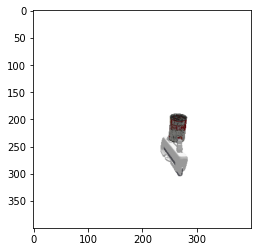

In [27]:
query_img_f = os.path.join(val_images_dir, query_gripper, f"img_graspnum_{query_gnum}.png")
q_img = Image.open(query_img_f)
print("QUERY IMAGE")
plt.imshow(q_img)

CLOSEST according to Contact Map (G.T)


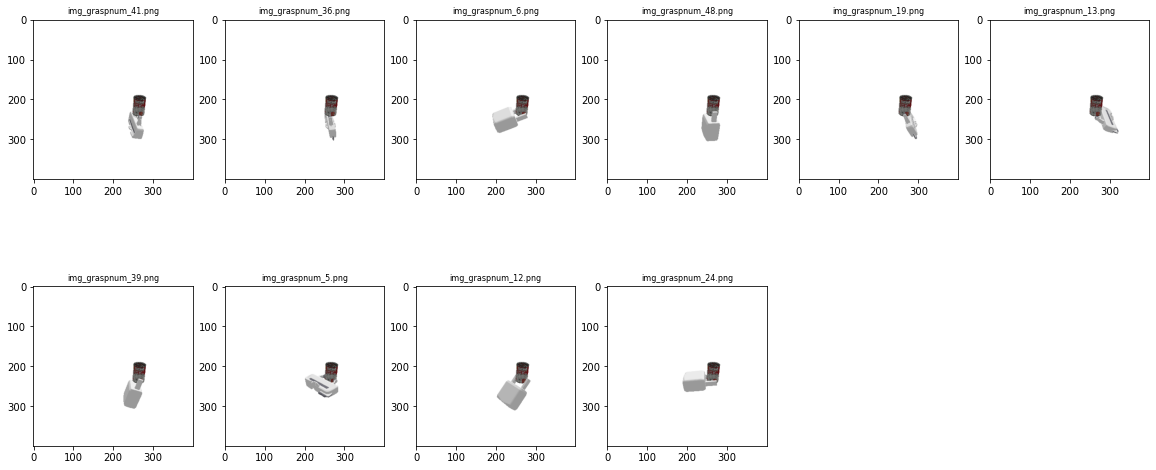

In [28]:
print("CLOSEST according to Contact Map (G.T)")

display_images(imgs_close_cmap, overall_title="Closest Cmap (GT)")

CLOSEST according to Learned latent vector (Z) space


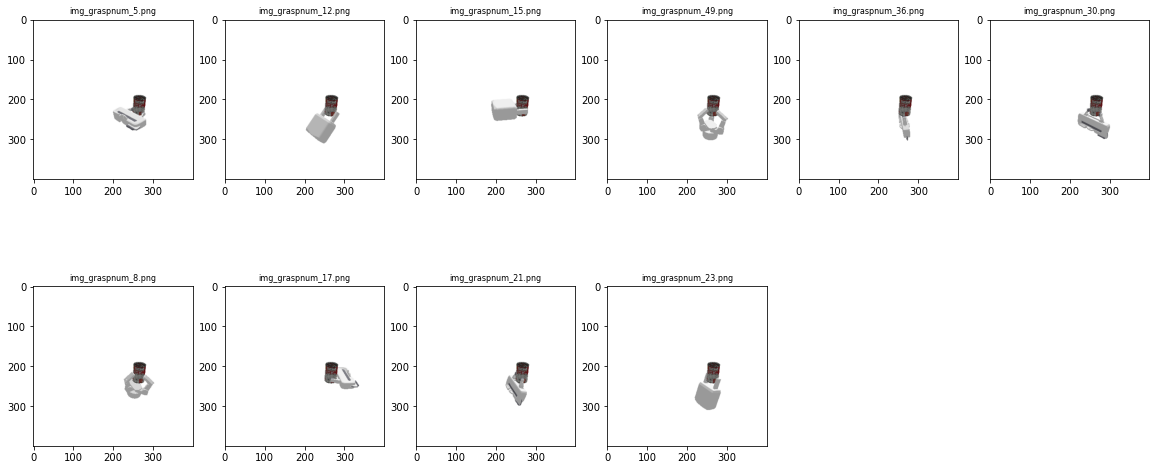

In [29]:
print("CLOSEST according to Learned latent vector (Z) space")

display_images(imgs_close_lv, overall_title="Closest L.V")

FARTHEST according to Contact Map (G.T)


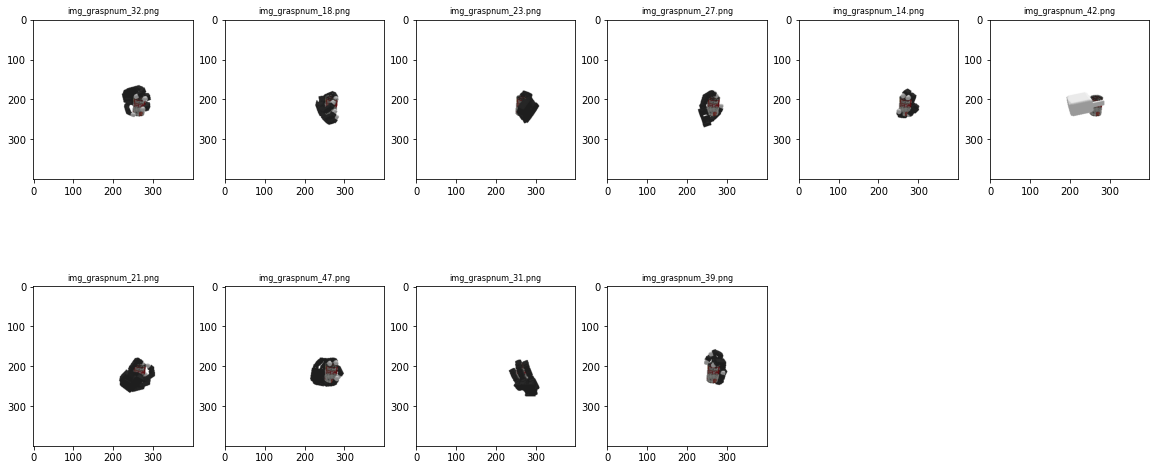

In [30]:
print("FARTHEST according to Contact Map (G.T)")

display_images(imgs_far_cmap, overall_title="FARTHEST Cmap (GT)")

FARTHEST according to Learned latent vector (Z) space


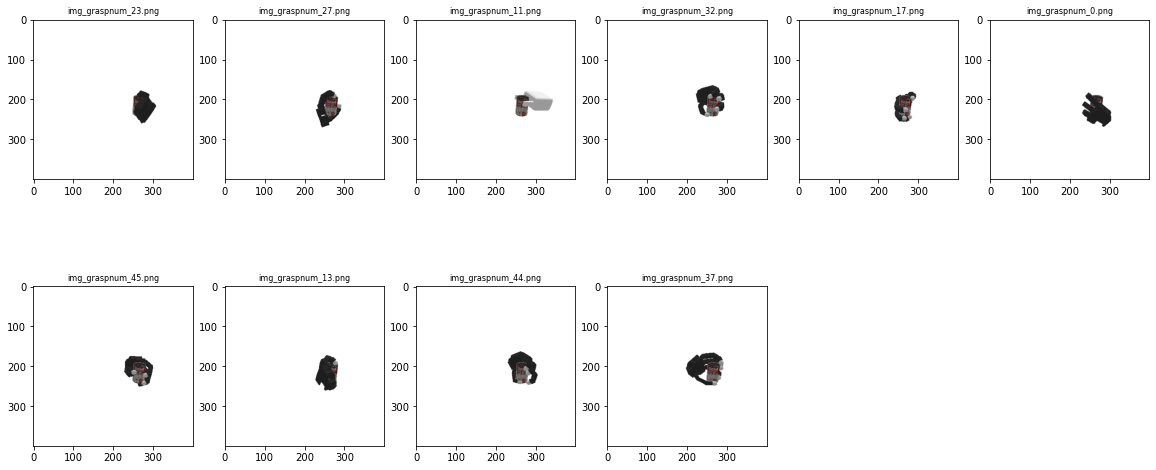

In [31]:
print("FARTHEST according to Learned latent vector (Z) space")

display_images(imgs_far_lv, overall_title="FARTHEST L.V")